In [1]:
from fastai.vision.all import *
import fastai
import timm
import torch

In [2]:
torch.cuda.set_device(0)

In [3]:
df = pd.read_csv('../trainValid.csv')

In [4]:
df

,Unnamed: 0,nombre_foto,grado de DMAE,binary,set
0,61504,anonymized_231059.jpg,normal,0,training
1,176989,anonymized_442122.jpg,normal,0,training
2,133399,anonymized_363034.jpg,normal,0,training
3,220150,anonymized_519072.jpg,normal,0,training
4,155853,anonymized_403989.jpg,normal,0,training
...,...,...,...,...,...
7797,224854,anonymized_528388.jpg,tardia,1,validation
7798,225492,anonymized_529721.jpg,intermedia,1,validation
7799,226322,anonymized_531350.jpg,precoz,1,validation
7800,227489,anonymized_533460.jpg,tardia,1,validation


In [5]:
def is_valid(path):
    name = path[1]
    return (df[df['nombre_foto']==name])['set'].values[0]=='validation'

# 224

In [1]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='hrnet_w32_224',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [7]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [8]:
dls = db.dataloaders(df.values,bs=64,num_workers=0)

In [9]:
learn = Learner(dls,timm.create_model('hrnet_w32',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

SuggestedLRs(valley=0.00010964782268274575)

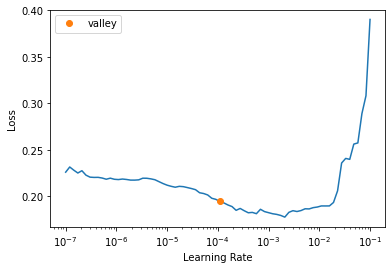

In [10]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.130629,0.587715,0.500000,0.500000,1.000000,0.666667,0.652666,01:55


Better model found at epoch 0 with f1_score value: 0.6666666666666666.


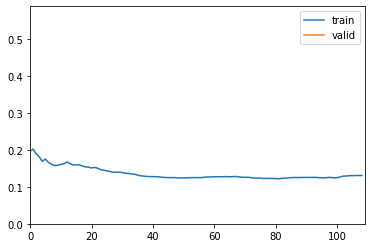

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.093861,0.077668,0.878205,0.906336,0.843590,0.873838,0.951765,01:55
1,0.082283,0.069920,0.888462,0.899736,0.874359,0.886866,0.958514,01:55
2,0.075882,0.075665,0.885897,0.912329,0.853846,0.882119,0.957978,01:55
3,0.076139,0.075466,0.885897,0.941349,0.823077,0.878249,0.958504,01:56
4,0.071525,0.067640,0.894872,0.916216,0.869231,0.892105,0.962130,01:55
5,0.069409,0.078058,0.885897,0.921569,0.843590,0.880857,0.953744,01:55
6,0.074613,0.071776,0.894872,0.888889,0.902564,0.895674,0.958350,01:55
7,0.069891,0.087709,0.884615,0.912088,0.851282,0.880637,0.954836,01:55
8,0.071218,0.077682,0.894872,0.927778,0.856410,0.890667,0.952840,01:56
9,0.068260,0.065724,0.902564,0.894472,0.912821,0.903553,0.969941,01:56


Better model found at epoch 0 with f1_score value: 0.8738379814077026.


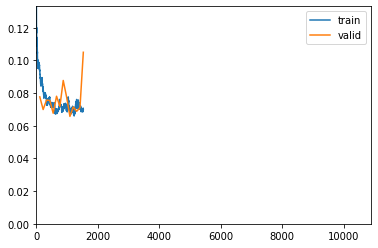

Better model found at epoch 1 with f1_score value: 0.8868660598179454.
Better model found at epoch 4 with f1_score value: 0.8921052631578946.
Better model found at epoch 6 with f1_score value: 0.8956743002544529.
Better model found at epoch 9 with f1_score value: 0.9035532994923858.
No improvement since epoch 9: early stopping


In [11]:
learn.fine_tune(100,base_lr=3e-3)

In [12]:
dfTest = pd.read_csv('../testSample.csv')

In [13]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [14]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [15]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=64,num_workers=0)

In [16]:
learn.dls = dlsTest

In [17]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9572791584483891.


(#6) [0.08132432401180267,0.8897435665130615,0.8762376237623762,0.9076923076923077,0.8916876574307305,0.9572791584483891]

# 384

In [7]:
import torch
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='hrnet_w32_384',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [8]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [9]:
dls = db.dataloaders(df.values,bs=32,num_workers=0)

In [10]:
learn = Learner(dls,timm.create_model('hrnet_w32',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

In [11]:
learn.load('hrnet_w32_224')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(valley=0.0003311311302240938)

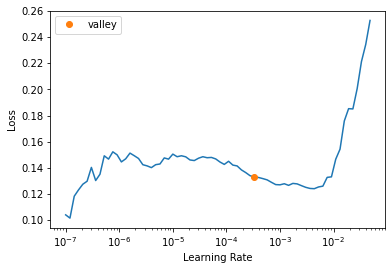

In [12]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.162191,0.348883,0.582051,0.559701,0.769231,0.647948,0.634451,03:33


Better model found at epoch 0 with f1_score value: 0.6479481641468682.


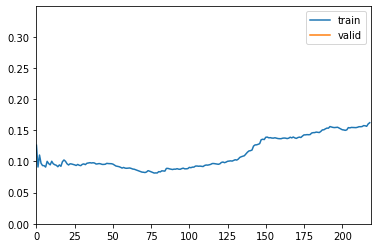

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.101043,0.104622,0.819231,0.933798,0.687179,0.791728,0.932377,03:37
1,0.085157,0.073282,0.884615,0.909836,0.853846,0.880952,0.954698,03:36
2,0.084919,0.075516,0.884615,0.931034,0.830769,0.878049,0.954303,03:36
3,0.081548,0.084885,0.885897,0.862651,0.917949,0.889441,0.946032,03:36
4,0.076022,0.083774,0.884615,0.938596,0.823077,0.877049,0.949188,03:36
5,0.080051,0.098133,0.870513,0.958730,0.774359,0.856738,0.947978,03:36
6,0.085246,0.078988,0.878205,0.940299,0.807692,0.868966,0.955437,03:36


Better model found at epoch 0 with f1_score value: 0.7917282127031019.


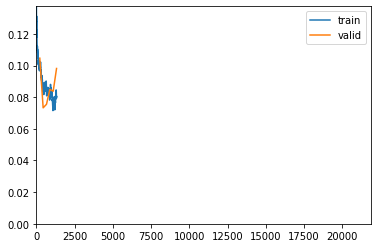

Better model found at epoch 1 with f1_score value: 0.880952380952381.
Better model found at epoch 3 with f1_score value: 0.8894409937888199.
No improvement since epoch 1: early stopping


In [13]:
learn.fine_tune(100,base_lr=3e-3)

In [14]:
dfTest = pd.read_csv('../testSample.csv')

In [15]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [16]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [17]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=64,num_workers=0)

In [18]:
learn.dls = dlsTest

In [19]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9305756738987507.


(#6) [0.10561945289373398,0.8712820410728455,0.8460803059273423,0.9076923076923077,0.8758040573973281,0.9305756738987507]

# 512

In [6]:
import torch
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='hrnet_w32_512',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [7]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(640)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=512, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [8]:
dls = db.dataloaders(df.values,bs=8,num_workers=0)

In [9]:
learn = Learner(dls,timm.create_model('hrnet_w32',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

In [10]:
learn.load('hrnet_w32_384')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(valley=2.0892961401841603e-05)

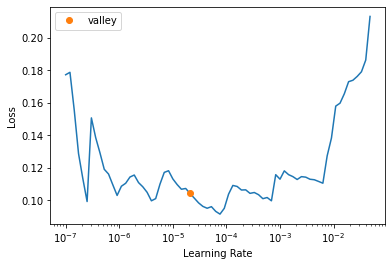

In [11]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.105648,0.141060,0.788462,0.982833,0.587179,0.735152,0.928537,08:20


Better model found at epoch 0 with f1_score value: 0.7351524879614768.


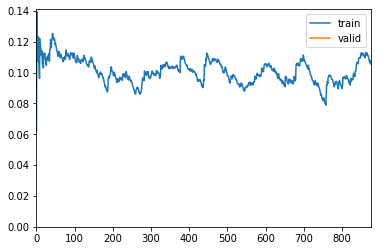

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.079981,0.071335,0.891026,0.947214,0.828205,0.883721,0.960306,08:26
1,0.088528,0.071514,0.889744,0.939306,0.833333,0.883152,0.958846,08:26
2,0.087150,0.077943,0.883333,0.951662,0.807692,0.873786,0.959109,08:27
3,0.072299,0.074024,0.887179,0.936416,0.830769,0.880435,0.960411,08:23
4,0.090225,0.070703,0.891026,0.932011,0.843590,0.885599,0.959116,08:21
5,0.066453,0.075142,0.894872,0.940000,0.843590,0.889189,0.957202,08:24
6,0.082055,0.073090,0.897436,0.950581,0.838462,0.891008,0.958662,08:21
7,0.080148,0.083395,0.869231,0.880952,0.853846,0.867188,0.944122,08:22
8,0.073583,0.070376,0.893590,0.925208,0.856410,0.889481,0.961732,08:22
9,0.065674,0.070737,0.892308,0.902632,0.879487,0.890909,0.962778,08:23


Better model found at epoch 0 with f1_score value: 0.8837209302325582.


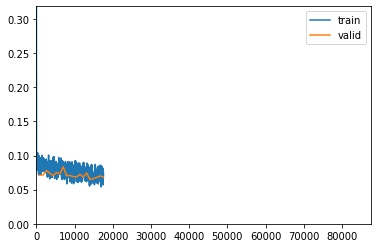

Better model found at epoch 4 with f1_score value: 0.8855989232839838.
Better model found at epoch 5 with f1_score value: 0.8891891891891892.
Better model found at epoch 6 with f1_score value: 0.8910081743869209.
Better model found at epoch 10 with f1_score value: 0.8981233243967829.
Better model found at epoch 11 with f1_score value: 0.8982826948480847.
Better model found at epoch 15 with f1_score value: 0.9062901155327343.
No improvement since epoch 15: early stopping


In [12]:
learn.fine_tune(100,base_lr=3e-4)

In [13]:
dfTest = pd.read_csv('../testSample.csv')

In [14]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [15]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(640)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=512, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [16]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=8,num_workers=0)

In [17]:
learn.dls = dlsTest

In [18]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9582685075608153.


(#6) [0.07232306152582169,0.8989743590354919,0.9010309278350516,0.8964102564102564,0.8987146529562982,0.9582685075608153]

In [17]:
preds,y=learn.tta()

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [19]:
import numpy as np

In [20]:
np.argmax(preds,axis=1)

tensor([0, 0, 0,  ..., 1, 1, 0])

In [21]:
f1_score(np.argmax(preds,axis=1),y)

0.9161091096242923

In [22]:
precision_score(np.argmax(preds,axis=1),y)

0.9128205128205128

In [23]:
recall_score(np.argmax(preds,axis=1),y)

0.9194214876033058